Installing and Importing Required Packages

In [208]:
!pip install emoji
!pip install nlpaug
!pip install nltk


In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, string, emoji, nltk, joblib
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from scipy.sparse import hstack

Importing Dataset

In [253]:
train_df = pd.read_csv("train.csv")
train_df.rename(columns={'target': 'label'}, inplace=True)

print("Dataset shape:", train_df.shape)

Dataset shape: (7613, 5)


In [254]:
train_df.head()

,id,keyword,location,text,label
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


EDA and Cleaning

In [255]:
print(train_df.isnull().sum())

missing_percent = train_df.isnull().sum() / len(train_df) * 100
print("\nMissing Value Percentage:\n", missing_percent)

id             0
keyword       61
location    2533
text           0
label          0
dtype: int64

Missing Value Percentage:
 id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
label        0.000000
dtype: float64


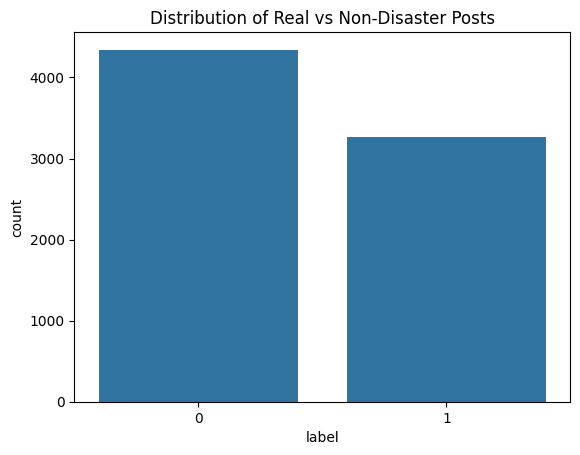

Unique Keywords: 221
Unique Locations: 3341


In [256]:
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Real vs Non-Disaster Posts')
plt.show()

print("Unique Keywords:", train_df['keyword'].nunique())
print("Unique Locations:", train_df['location'].nunique())


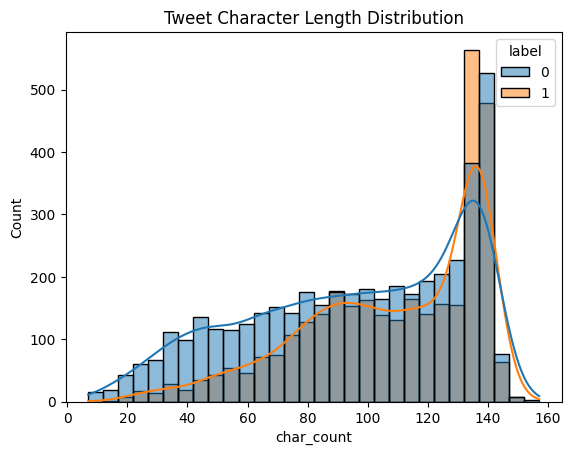

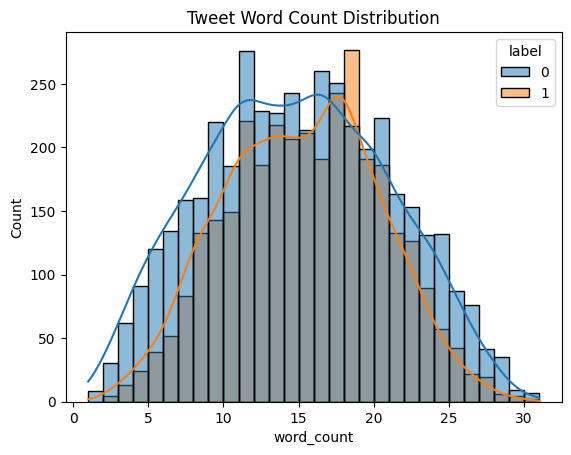

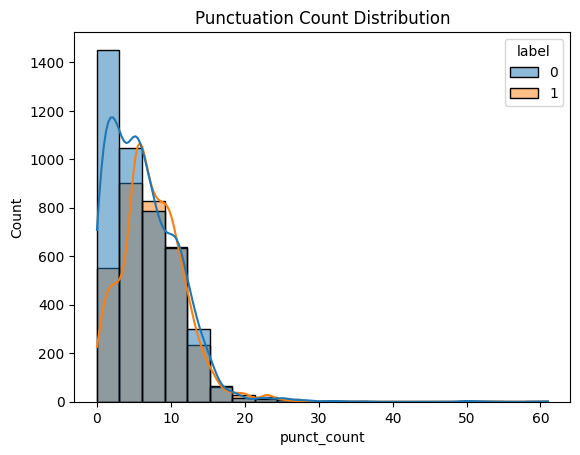

In [258]:
# Tweet length (characters) by class
train_df['char_count'] = train_df['text'].apply(len)
sns.histplot(data=train_df, x='char_count', hue='label', bins=30, kde=True)
plt.title("Tweet Character Length Distribution")
plt.show()

# Word count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=train_df, x='word_count', hue='label', bins=30, kde=True)
plt.title("Tweet Word Count Distribution")
plt.show()

# Punctuation count
train_df['punct_count'] = train_df['text'].apply(lambda x: len([c for c in x if c in string.punctuation]))
sns.histplot(data=train_df, x='punct_count', hue='label', bins=20, kde=True)
plt.title("Punctuation Count Distribution")
plt.show()


Top 10 keywords (disaster):
 keyword
unknown              42
derailment           39
outbreak             39
wreckage             39
debris               37
oil%20spill          37
typhoon              37
rescuers             32
suicide%20bomb       32
suicide%20bombing    32
Name: count, dtype: int64

Top 10 keywords (non-disaster):
 keyword
body%20bags    40
armageddon     37
harm           37
ruin           36
wrecked        36
deluge         36
explode        35
twister        35
fear           35
siren          35
Name: count, dtype: int64


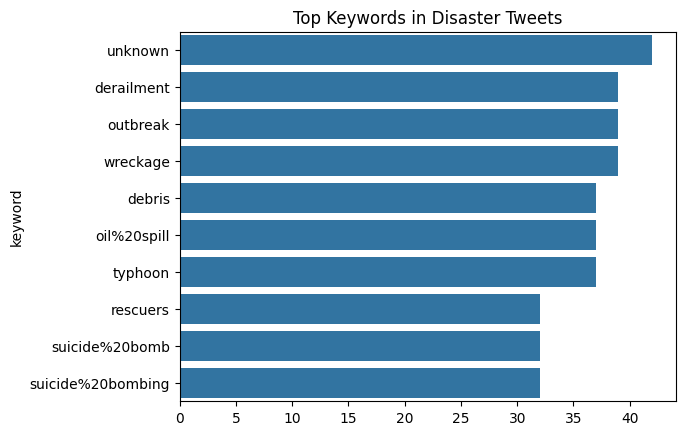

In [259]:
# Fill missing for analysis
train_df['keyword'] = train_df['keyword'].fillna('unknown')
train_df['location'] = train_df['location'].fillna('unknown')

# Top 10 keywords for disaster tweets
top_keywords_real = train_df[train_df['label']==1]['keyword'].value_counts().head(10)
top_keywords_non = train_df[train_df['label']==0]['keyword'].value_counts().head(10)

print("Top 10 keywords (disaster):\n", top_keywords_real)
print("\nTop 10 keywords (non-disaster):\n", top_keywords_non)

# Visualization
sns.barplot(x=top_keywords_real.values, y=top_keywords_real.index)
plt.title("Top Keywords in Disaster Tweets")
plt.show()


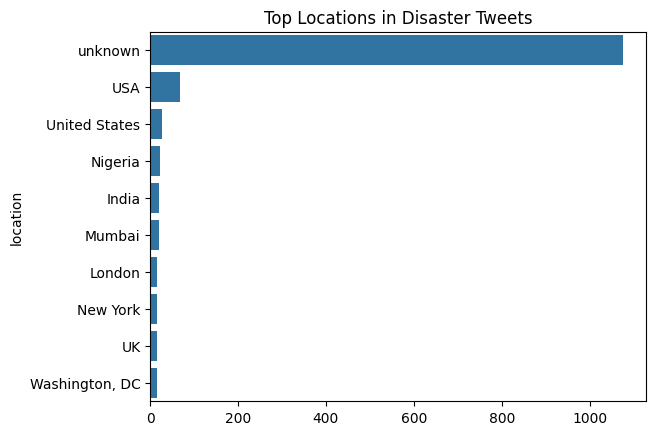

In [260]:
# Location analysis (optional if many missing)
top_locations_real = train_df[train_df['label']==1]['location'].value_counts().head(10)
sns.barplot(x=top_locations_real.values, y=top_locations_real.index)
plt.title("Top Locations in Disaster Tweets")
plt.show()


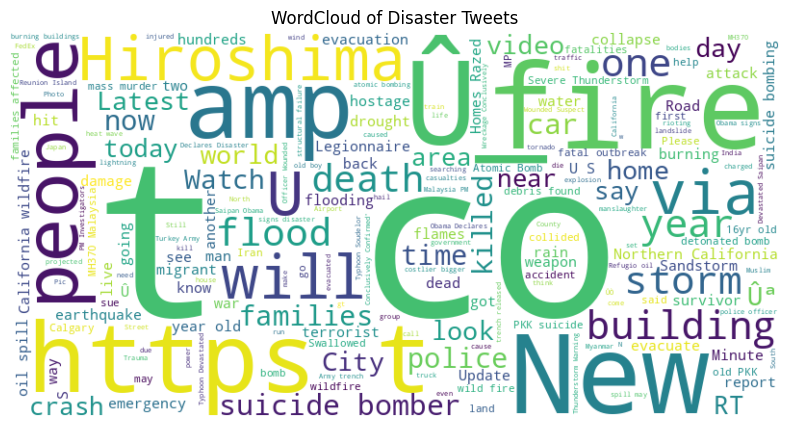

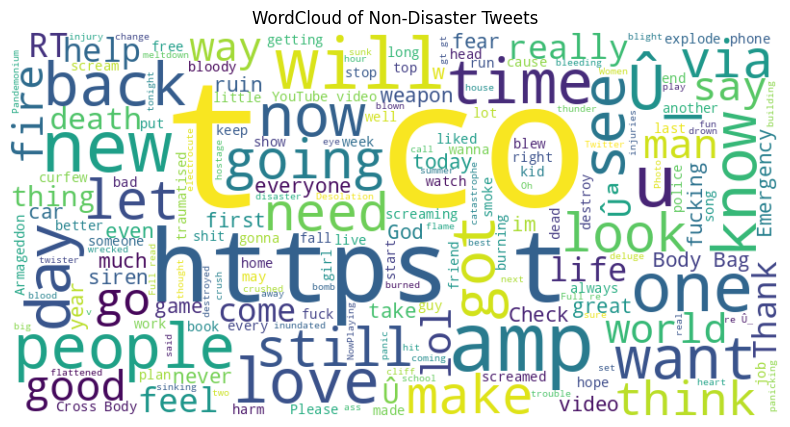

In [261]:
from wordcloud import WordCloud

# Disaster tweets
text_real = " ".join(train_df[train_df['label']==1]['text'].dropna())
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(text_real)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Disaster Tweets")
plt.show()

# Non-disaster tweets
text_non = " ".join(train_df[train_df['label']==0]['text'].dropna())
wordcloud_non = WordCloud(width=800, height=400, background_color='white').generate(text_non)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_non, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Non-Disaster Tweets")
plt.show()


In [262]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(words)

train_df['clean_text'] = train_df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


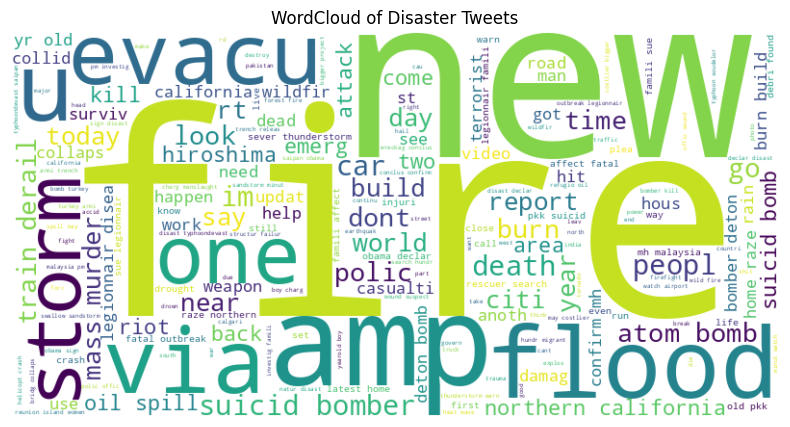

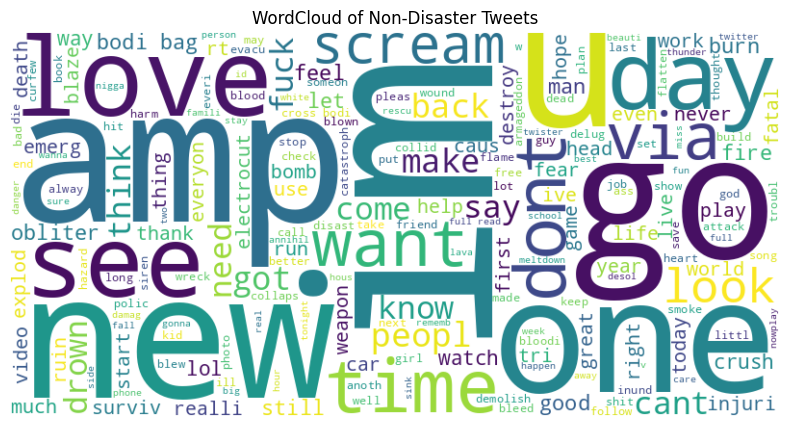

In [263]:
from wordcloud import WordCloud

# Disaster tweets
text_real = " ".join(train_df[train_df['label']==1]['clean_text'].dropna())
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(text_real)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Disaster Tweets")
plt.show()

# Non-disaster tweets
text_non = " ".join(train_df[train_df['label']==0]['clean_text'].dropna())
wordcloud_non = WordCloud(width=800, height=400, background_color='white').generate(text_non)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_non, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Non-Disaster Tweets")
plt.show()


In [264]:
train_df.head()

,id,keyword,location,text,label,char_count,word_count,punct_count,clean_text
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,69,13,1,deed reason earthquak may allah forgiv us
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,38,7,1,forest fire near la rong sask canada
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1,133,22,3,resid ask shelter place notifi offic evacu she...
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,65,8,2,peopl receiv wildfir evacu order california
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,88,16,2,got sent photo rubi alaska smoke wildfir pour ...


In [265]:
# train_df['char_count'] = train_df['text'].apply(len)
# train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
# train_df['punct_count'] = train_df['text'].apply(lambda x: len([c for c in x if c in string.punctuation]))

X_train, X_val, y_train, y_val = train_test_split(
    train_df[['clean_text', 'char_count', 'word_count', 'punct_count']],
    train_df['label'],
    test_size=0.2,
    stratify=train_df['label'],
    random_state=42
)

TF-IDF and Standard Scaler

In [266]:
tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train['clean_text'])
X_val_tfidf = tfidf.transform(X_val['clean_text'])

print("TF-IDF matrix shape (train):", X_train_tfidf.shape)
print("TF-IDF matrix shape (val):", X_val_tfidf.shape)

TF-IDF matrix shape (train): (6090, 8000)
TF-IDF matrix shape (val): (1523, 8000)


In [267]:
scaler = StandardScaler(with_mean=False)
X_train_num = scaler.fit_transform(X_train[['char_count','word_count','punct_count']])
X_val_num = scaler.transform(X_val[['char_count','word_count','punct_count']])

print("Standard Scaler matrix shape (train):", X_train_num.shape)
print("Standard Scaler matrix shape (val):", X_val_num.shape)

Standard Scaler matrix shape (train): (6090, 3)
Standard Scaler matrix shape (val): (1523, 3)


In [268]:
X_train_combined = hstack((X_train_tfidf, X_train_num))
X_val_combined = hstack((X_val_tfidf, X_val_num))

print("Combined matrix shape (train):", X_train_combined.shape)
print("COmbined Scaler matrix shape (val):", X_val_combined.shape)

Combined matrix shape (train): (6090, 8003)
COmbined Scaler matrix shape (val): (1523, 8003)


Testing on Models

In [269]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

results = []

In [270]:
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_val_tfidf)

    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1
    })


In [271]:
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
print("Model Comparison:\n")
print(results_df)


Model Comparison:

                 Model  Accuracy  F1-Score
0  Logistic Regression  0.821405  0.774461
1          Naive Bayes  0.815496  0.756288
2        Random Forest  0.798424  0.752220
3              XGBoost  0.787262  0.717277


Hyperparameter Tuning

In [272]:
print("Hyperparameter Tuning in progress...")

# Logistic Regression
param_grid_lr = {
    'C': [0.5, 1, 2, 3, 5],
    'solver': ['liblinear', 'lbfgs']
}
grid_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid_lr,
    scoring='f1',
    cv=5,
    n_iter=6,
    n_jobs=-1,
    random_state=42
)
grid_lr.fit(X_train_tfidf, y_train)
best_lr = grid_lr.best_estimator_
print("Best LR params:", grid_lr.best_params_)

# XGBoost
param_grid_xgb = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.08, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
grid_xgb = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid_xgb,
    scoring='f1',
    cv=3,
    n_iter=8,
    n_jobs=-1,
    random_state=42
)
grid_xgb.fit(X_train_combined, y_train)
best_xgb = grid_xgb.best_estimator_
print("Best XGB params:", grid_xgb.best_params_)

Hyperparameter Tuning in progress...
Best LR params: {'solver': 'lbfgs', 'C': 2}
Best XGB params: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


Tuned Logistic Regression

In [273]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

best_lr = LogisticRegression(
    solver='lbfgs',
    C=2,
    random_state=42
)

best_lr.fit(X_train_combined, y_train)

y_pred_lr = best_lr.predict(X_val_combined)
acc_lr = accuracy_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)

print(f"Tuned Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"Tuned Logistic Regression F1-Score: {f1_lr:.4f}")


Tuned Logistic Regression Accuracy: 0.8043
Tuned Logistic Regression F1-Score: 0.7631


Ensemble Soft Voting Classifier

LR+NB+RF+XGB

In [274]:
nb = MultinomialNB(alpha=0.5)
rf = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)

voting = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('nb', nb),
        ('rf', rf),
        ('xgb', best_xgb)
    ],
    voting='soft'
)
voting.fit(X_train_combined, y_train)

y_pred = voting.predict(X_val_combined)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Tuned Ensemble Accuracy: {acc:.4f}")
print(f"Tuned Ensemble F1-Score: {f1:.4f}")

Tuned Ensemble Accuracy: 0.8221
Tuned Ensemble F1-Score: 0.7662


LR+NB

In [276]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('nb', MultinomialNB())
    ],
    voting='soft',
    weights=[0.8, 0.2]
)

ensemble.fit(X_train_combined, y_train)
y_pred_ensemble = ensemble.predict(X_val_combined)

acc_ens = accuracy_score(y_val, y_pred_ensemble)
f1_ens = f1_score(y_val, y_pred_ensemble)

print(f"Ensemble (LR + NB) Accuracy: {acc_ens:.4f}")
print(f"Ensemble (LR + NB) F1-Score: {f1_ens:.4f}")


Ensemble (LR + NB) Accuracy: 0.8162
Ensemble (LR + NB) F1-Score: 0.7701


LR+XGB

In [277]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train['clean_text'])
X_val_tfidf = tfidf.transform(X_val['clean_text'])

scaler = StandardScaler(with_mean=False)
X_train_num = scaler.fit_transform(X_train[['char_count','word_count','punct_count']])
X_val_num = scaler.transform(X_val[['char_count','word_count','punct_count']])

X_train_combined = hstack((X_train_tfidf, X_train_num))
X_val_combined = hstack((X_val_tfidf, X_val_num))

lr_model = LogisticRegression(solver='lbfgs', C=2, max_iter=2000, random_state=42)

xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

X_train_dense = X_train_combined.toarray()
X_val_dense = X_val_combined.toarray()

ensemble_lrxgb = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('xgb', xgb_model)
    ],
    voting='soft',
    weights=[0.7, 0.3]
)

ensemble_lrxgb.fit(X_train_dense, y_train)

y_pred = ensemble_lrxgb.predict(X_val_dense)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Ensemble (LR + XGB) Accuracy: {acc:.4f}")
print(f"Ensemble (LR + XGB) F1-Score: {f1:.4f}")

Ensemble (LR + XGB) Accuracy: 0.8050
Ensemble (LR + XGB) F1-Score: 0.7607


Best Accuracy and F1 Score for Logistic Regression with default hyperparameters

In [278]:
#Logistic Regression
model_fin = LogisticRegression(max_iter=1000, random_state=42)

model_fin.fit(X_train_combined, y_train)
preds = model_fin.predict(X_val_combined)

acc = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds)

print(
    f"Logistic Regression Accuracy: {acc:.4f}\n"
    f"Logistic Regression F1-Score: {f1:.4f}"
)

Logistic Regression Accuracy: 0.8024
Logistic Regression F1-Score: 0.7578


Cross Validation

In [279]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = np.mean(
    cross_val_score(model_fin, X_train_tfidf, y_train, cv=kfold, scoring='f1', n_jobs=-1)
)
print(f"5-Fold LR Mean F1: {cv_scores:.4f}")

5-Fold LR Mean F1: 0.7367


In [280]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scorer = make_scorer(f1_score)

f1_scores = cross_val_score(model_fin, X_train_tfidf, y_train, cv=kf, scoring=f1_scorer, n_jobs=-1)

acc_scores = cross_val_score(model_fin, X_train_tfidf, y_train, cv=kf, scoring='accuracy', n_jobs=-1)

print(f"5-Fold CV F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"5-Fold CV Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")


5-Fold CV F1-Score: 0.7367 ± 0.0117
5-Fold CV Accuracy: 0.7975 ± 0.0078


Saving Model and Vectorizer

In [281]:
joblib.dump(model_fin, "best_tuned_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Saved tuned model and vectorizer successfully!")

Saved tuned model and vectorizer successfully!
